In [26]:
import numpy as np
import random
from copy import deepcopy
from time import sleep
from matplotlib import pyplot as plt
from collections import namedtuple
import sys
from random import random as rand
from sys import path
from os import getcwd
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns

In [1]:
"""
MATLAB version AUTHOR:
    Dr. Cynthia Sung (crsung@seas.upenn.edu)
    Modified by Gedaliah Knizhnik (knizhnik@seas.upenn.edu) 08/28/19
Python version transformed AUTHOR:
    Zichen Lao (lao0910@seas.upenn.edu) 06/05/20
"""

import numpy as np

class calculateFK():

    def __init__(self):
        """
        This is the dimension of the Lynx Robot stated as global variable

        """
        # Lynx Dimensions in mm
        self.L1 = 76.2    # distance between joint 0 and joint 1
        self.L2 = 146.05  # distance between joint 1 and joint 2
        self.L3 = 187.325 # distance between joint 2 and joint 3
        self.L4 = 34      # distance between joint 3 and joint 4
        self.L5 = 34      # distance between joint 4 and center of gripper

        # Joint limits
        self.lowerLim = np.array([-1.4, -1.2, -1.8, -1.9, -2.0, -15]).reshape((1, 6))    # Lower joint limits in radians (grip in mm (negative closes more firmly))
        self.upperLim = np.array([1.4, 1.4, 1.7, 1.7, 1.5, 30]).reshape((1, 6))          # Upper joint limits in radians (grip in mm)

    def forward(self, q):
        """
        INPUT:
        q - 1x6 vector of joint inputs [q0,q1,q2,q3,q4,lg]

        OUTPUTS:
        jointPositions - 6 x 3 matrix, where each row represents one
                  joint along the robot. Each row contains the [x,y,z]
                  coordinates of the respective joint's center (mm). For
                  consistency, the first joint should be located at
                  [0,0,0].
        T0i       - a 4 x 4 x 6 list of homogeneous transformation matrix,
                  representing the joint frames expressed in the
                  base (0) frame. T0i[:,:,i] is the ith-1 joint
        """
        # Your code starts from here
        # Frame 1 w.r.t Frame 0
        T1 = np.array([[np.cos(q[0]), -np.sin(q[0])*np.cos(-np.pi/2), np.sin(q[0])*np.sin(-np.pi/2), 0],
                       [np.sin(q[0]), np.cos(q[0])*np.cos(-np.pi/2), -np.cos(q[0])*np.sin(-np.pi/2), 0],
                       [0, np.sin(-np.pi/2), np.cos(-np.pi/2), self.L1],
                       [0, 0, 0, 1]])

        # Frame 2 w.r.t Frame 1
        T2 = np.array([[np.cos(q[1]-(np.pi/2)), -np.sin(q[1]-(np.pi/2)), 0, self.L2*np.cos(q[1]-(np.pi/2))],
                       [np.sin(q[1]-(np.pi/2)), np.cos(q[1]-(np.pi/2)), 0, self.L2*np.sin(q[1]-(np.pi/2))],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])

        # Frame 3 w.r.t Frame 2
        T3 = np.array([[np.cos(q[2]+(np.pi/2)), -np.sin(q[2]+(np.pi/2)), 0, self.L3*np.cos(q[2]+(np.pi/2))],
                       [np.sin(q[2]+(np.pi/2)), np.cos(q[2]+(np.pi/2)), 0, self.L3*np.sin(q[2]+(np.pi/2))],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1]])

        # Frame 4 w.r.t Frame 3
        T4 = np.array([[np.cos(q[3]-(np.pi/2)), -np.sin(q[3]-(np.pi/2))*np.cos(-np.pi/2), np.sin(q[3]-(np.pi/2))*np.sin(-np.pi/2), 0],
                       [np.sin(q[3]-(np.pi/2)), np.cos(q[3]-(np.pi/2))*np.cos(-np.pi/2), -np.cos(q[3]-(np.pi/2))*np.sin(-np.pi/2), 0],
                       [0, np.sin(-np.pi/2), np.cos(-np.pi/2), 0],
                       [0, 0, 0, 1]])
        # Frame 5 w.r.t Frame 4
        T5 = np.array([[np.cos(q[4]), -np.sin(q[4]), 0, 0],
                       [np.sin(q[4]), np.cos(q[4]), 0, 0],
                       [0, 0, 1, self.L4 + self.L5],
                       [0, 0, 0, 1]])

        x = np.empty((6, 4)).reshape((6, 4))
        zeroPos = np.array([0, 0, 0, 1]).reshape((1, 4))
        zeroPos_trans = np.transpose(zeroPos)

        # Position of First Joint (Base Revolute)
        x[0, :] = zeroPos

        # Position of Second Joint (Shoulder Revolute)
        x[1, :] = np.transpose(T1.dot(zeroPos_trans))

        # Position of Third Joint (Elbow Revolute)
        x[2, :] = np.transpose((T1.dot(T2)).dot(zeroPos_trans))

        # Position of Fourth Joint (1st Wrist)
        x[3, :] = np.transpose(((T1.dot(T2)).dot(T3)).dot(zeroPos_trans))

        # Position of Fifth Joint (2nd Wrist)
        x[4, :] = np.transpose((((T1.dot(T2)).dot(T3)).dot(T4)).dot(np.array([0, 0, self.L4, 1]).reshape((4, 1))))

        # Position of Gripper (Base of the Gripper)
        x[5, :] = np.transpose(((((T1.dot(T2)).dot(T3)).dot(T4)).dot(T5)).dot(zeroPos_trans))
        # Outputs the 6x3 of the locations of each joint in the Base Frame
        jointPositions = x[0:6,0:3]

        T0i=np.zeros((4,4,6))
        T0i[:, :, 0] = np.eye(4)
        T0i[:, :, 1] = T1
        T0i[:, :, 2] = T1.dot(T2)
        T0i[:, :, 3] = (T1.dot(T2)).dot(T3)
        T0i[:, :, 4] = ((T1.dot(T2)).dot(T3)).dot(T4)
        T0i[:, :, 5] = ((((T1.dot(T2)).dot(T3)).dot(T4)).dot(T5))

        return jointPositions, T0i


In [2]:
#distPointToBox
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

def distPointToBox(p, box):
    """
    Calculate the distance between a point and an axis-aligned box.
    :param p: Nx3 vector of points [x,y,z]
    :param box: 1x6 vector of minimum and maximum points of box
    :return
    dist - Nx1 vector of distance between the points and the box
            dist > 0 point outside
            dist = 0 point is on or inside box
    unit - Nx3 vector where each row is the corresponding unit vector to the closest spot on the box
        norm(unit) = 1 point is outside the box
        norm(unit)= 0 point is on/inside the box

     Method from MultiRRomero
     @ https://stackoverflow.com/questions/5254838/calculating-distance-between-a-point-and-a-rectangular-box-nearest-point
    """
    # Get box info
    boxMin = np.array([box[0], box[1], box[2]])
    boxMax = np.array([box[3], box[4], box[5]])
    boxCenter = boxMin*0.5 + boxMax*0.5
    p = np.array(p)

    # Get distance info from point to box boundary
    dx = np.amax(np.vstack([boxMin[0] - p[:, 0], p[:, 0] - boxMax[0], np.zeros(p[:, 0].shape)]).T, 1)
    dy = np.amax(np.vstack([boxMin[1] - p[:, 1], p[:, 1] - boxMax[1], np.zeros(p[:, 1].shape)]).T, 1)
    dz = np.amax(np.vstack([boxMin[2] - p[:, 2], p[:, 2] - boxMax[2], np.zeros(p[:, 2].shape)]).T, 1)

    # convert to distance
    distances = np.vstack([dx, dy, dz]).T
    dist = np.linalg.norm(distances, axis=1)

    # Figure out the signs
    signs = np.sign(boxCenter-p)

    # Calculate unit vector and replace with
    unit = distances / dist[:, np.newaxis] * signs
    unit[np.isnan(unit)] = 0
    unit[np.isinf(unit)] = 0
    return dist, unit


# if __name__=='__main__':
#     box = [-1, -1, -1, 1, 1, 1]
#     p = [[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [-3, -3, -3]]
#     dist, unit = distPointToBox(p, box)
#     print(unit)
#     print(dist)




In [3]:
#Loadmap
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Writen Shane Rozen-Levy 10/3/20
"""

import numpy as np
from collections import namedtuple


def loadmap(filename):
    """
    :param filename: string with the location of the map file
    :return: map struct with boundary and obstacles element
                map.obstacles [Nx6] array of the obstacle boundaries
                map.boundary [6] array of the map boundary
    """
    obstacles = []
    boundary = []
    with open(filename, 'r') as reader:
        # Read file line by line
        line = reader.readline()
        while line != '':  # The EOF char is an empty string
            line = reader.readline()
            # Check to see if first character is b for boundary or block
            if len(line) > 0 and line[0] == 'b':
                words = line.split()
                # Check if block our boundary
                if words[0] == "block":
                    # Append to obstacles array or set to obstacles array
                    if len(obstacles) == 0:
                        obstacles = np.array([[float(words[i]) for i in range(1, len(words))]])
                    else:
                        obstacles = np.append(obstacles, np.array([[float(words[i]) for i in range(1, len(words))]]), axis=0)
                # Set boundary to the last boundary in file
                elif words[0] == "boundary":
                    boundary = np.array([float(words[i])  for i in range(1, len(words))])
    # Make sure atleast one boundary was in the file
    if len(boundary) == 0:
        raise Exception("Map file missing boundary")
    else:
        # Returns the map in a struct
        MyStruct = namedtuple("map", "obstacles boundary")
        return MyStruct(obstacles = obstacles, boundary = boundary)


In [4]:
# def calcJacobian(q, joint):
    
#     Jacv=np.zeros((3,6)) #zeroes after col: joint+1
#     Jacw=np.zeros((3,6)) #zeroes after col: joint+1
    
#     #For loop with the size of 3 x joint
#     R=calculateFK()
    
#     z=[] # np.array(3,joint)
#     z.append(np.array([0,0,1]))
#     z.append(np.array([-np.sin(q[0]),np.cos(q[0]),0]))
#     z.append(np.array([-np.sin(q[0]),np.cos(q[0]),0]))
#     z.append(np.array([-np.sin(q[0]),np.cos(q[0]),0]))
    
#     Jp,T0e=R.forward(q)
#     z.append([T0e[0,2],T0e[1,2],T0e[2,2]])
#     z.append([T0e[0,2],T0e[1,2],T0e[2,2]])
    
#     for i in range (1,joint+1):
#         Jo=Jp[5]-Jp[i-1]
#         Jr=np.cross(z[i-1],Jo)
#         Jacv[0,i-1]=Jr[0]
#         Jacv[1,i-1]=Jr[1]
#         Jacv[2,i-1]=Jr[2]

#     z = np.array(z)
#     z[joint+1:len(z)] *= 0
#     Jacw=np.transpose(np.array(z))
#     return (np.append(Jacv, Jacw, axis=0))

In [5]:
import numpy as np

def calcJacobian(q, joint):
    """
    Calculate the Jacobian of a particular joint of the  robot in a given configuration
    :param q: 1 x 6 vector of joint inputs [q1,q2,q3,q4,q5,q6]
    :param joint: scalar in [0,6] representing which joint we care about
    :return: J - 6 x (joint-1) matrix representing the Jacobian
    """

    if joint <= 1:
        return np.array([])
    FK = calculateFK()
    jointPositions, T0 = FK.forward(q)

    Jw1 = np.zeros((3, joint-1))

    for i in range(joint-1):
        Jw1[:, i] = T0[range(3), 2, i]

    Jv2 = np.zeros((3, joint-1))
    for i in range(joint-1):
        Jv2[:, i] = np.cross(T0[range(3), 2, i], jointPositions[joint-1, :].T - T0[range(3), 3, i])
    J = np.vstack((Jv2, Jw1))
    return J


In [ ]:
import numpy as np
def potentialFieldStep(qCurr, map_struct, qGoal):

    #constants to control
    zeta=2
    eta=0.0001
    rho0=0.0001
    alpha=0.015
    
    #intializing vectors
    Fatt=np.zeros((6, 3))
    Frep=np.zeros((6, 3))
    Fnet=np.zeros((6, 3))
    tor=np.zeros(6)
    
    
    R=calculateFK()
    Jp,T0e=R.forward(qCurr)
    Jpg,T0eg=R.forward(qGoal)
    #print("current position:",Jp[3])
    #print("goal position:",Jpg[3])
    #print("distance away:\n",Jp-Jpg)

    rho = []
    unit=[]
    for box in map_struct.obstacles:
        dist_i, unit_i = distPointToBox(Jp, box)
        rho.append(dist_i)
        unit.append(unit_i)

    
    for i in range(0,6):
        # Compute force of repulsion
        for j in range(len(rho)):
            # distance between joint and current obstacle
            drho=unit_i[j]
            # Add current obstacle's repulsive force to accumulated repulsive force on joint
            Frep[i] += eta*(1/rho[j][i] - 1/rho0)*(1/rho[j][i]**2)*drho
            
        Fatt[i] = -zeta*(Jp[i] - Jpg[i])
        Fnet[i] = Fatt[i] + Frep[i]
    #print("Fnet:",Fnet)
        
    #USING JACOBIAN:
    Jac1=np.zeros(3).reshape((3,1))
    Jac=calcJacobian(qCurr,6)[:3]
    Jac=np.hstack((Jac,Jac1))
    tori = np.matmul(Jac.T,Fnet.T)
    tor=np.sum(tori,axis=1)
    unit_tor=(tor)/np.linalg.norm(tor)
    unit_tor=np.nan_to_num(unit_tor,False,0)
    #unit_tor=np.append(unit_tor,[0])
    qNext = np.around(qCurr+alpha*(unit_tor),4)
    
    #Updating isDone
#     done=0
#     for r in range(0,3):
# #         print(abs(qNext[r]-qGoal[r]))
#         if abs(qNext[r]-qGoal[r])<0.05:
# #             print("joint value")
#             done+=1
#     print(done)

#     if done==3:
#         isDone=True
#     else:
#         isDone=False
    
    return qNext

In [129]:
#potentialFieldPath
import numpy as np
from copy import deepcopy
from time import sleep
import numpy as np
import sys
from random import random as rand
from sys import path
from os import getcwd


def potentialFieldPath(map_struct, qStart, qGoal):
    #need to define these variables
    
    thresh = 0.04
    
    ipath=[]
    path=[]
    isDoneArray = []
    qNext=potentialFieldStep(qStart,map_struct,qGoal)
    qNext[4]=qGoal[4]
    qNext[5]=qGoal[5]
    path.append(qNext)
    ipath.append(qNext)
    #isDoneArray.append(isDone)
    print("1st qCurr:",qNext)
    f=0
    isDone=False
    while isDone==False and f<=5000:
        f+=1
        qCurr=ipath[-1]
        qNext=potentialFieldStep(qCurr,map_struct,qGoal)
        ipath.append(qNext)
        done=0
        ind=0
        #print(ipath[-1][2])
        
        if(f%1000==0):
            print("iteration #:",f)
        
        if (f%100)==0:    
            path.append(qNext)
            if f>=1000:
                #IS DONE CHECK
                for r in range(0,3):
                    # print("how close we are to converging:",abs(qNext[r]-path[-4][r]))
                    if abs(qNext[r]-path[-4][r])<thresh:
                        done+=1
                print("done value:",done)
        
        #If isdone is true, We will check whether it reached its goal:
        if done==3:
            isDone=True
        g=0
        for r in range(0,3):
            #print("close to goal:",abs(qGoal[r]-path[-1][r]))
            if abs(qGoal[r]-path[-1][r])<thresh:
                g+=1
        if g==3:
            print("goal reached")
            isDone = True
    
    print("IsDone", isDone)
    print("g", g)
    if g != 3:
        
        numPoints = 1
        while(numPoints <= 10):
            
            print("numPoints", numPoints)
            
            print("stuck at minima. Initiating RRT")
            points = rrt(map_struct, path[-1], numPoints)
            print("Done rrt: ", points)

            rrt_goal=0
            for r in range(0,3):
                print("close to goal:",abs(points[-1][r]-path[-1][r]))
                if abs(points[-1][r]-path[-1][r])<thresh:
                    rrt_goal+=1
            if rrt_goal==3:
                print("goal reached through rrt")                
                path2 = potentialFieldPath(map_struct, points[-1], qGoal)
                path.append(points)
                path.append(path2)
                return (path) 
            numPoints+=1
        print("RRT was not able to reach the goal in numPoints")
    return path

In [144]:
qStart=[0,0,0,0,0,0]
qGoal=[0.1,0.5,1.2,0,0,0]
map_struct = loadmap("maps/map3.txt")
# print(map_struct.obstacles)

p=potentialFieldPath(map_struct,qStart,qGoal)
print(np.array(p).round(2))

1st qCurr: [0.0003 0.0078 0.0124 0.0033 0.     0.    ]
iteration #: 1000
done value: 3
IsDone True
g 2
numPoints 1
stuck at minima. Initiating RRT
(1) Above RRT While
(2.1) Generated RRT point
(2.1) Generated RRT point
max iterations reached
Done rrt:  [[0.0997, 0.5292, 1.1542, 0.3466, -0.0, 0.0], [-0.6929604465296652, 1.1027310723849995, 0.4720046458506879, 1.4223896531291071, -1.809078419372406, 0]]
close to goal: 0.7926604465296652
close to goal: 0.5735310723849995
close to goal: 0.682195354149312
numPoints 2
stuck at minima. Initiating RRT
(1) Above RRT While
(2.1) Generated RRT point
(2.1) Generated RRT point
(2.1) Generated RRT point
(2.1) Generated RRT point
max iterations reached
Done rrt:  [[0.0997, 0.5292, 1.1542, 0.3466, -0.0, 0.0], [1.0736758712289665, -0.8278822671719779, -0.7027354437832372, -1.8730545265735288, -0.24706450630835475, 0], [-0.3884150111398028, -0.7516160715831771, -1.4692842215546567, 1.383265862487716, -0.9834121758527055, 0]]
close to goal: 0.48811501113

Text(0.5, 0, 'x')

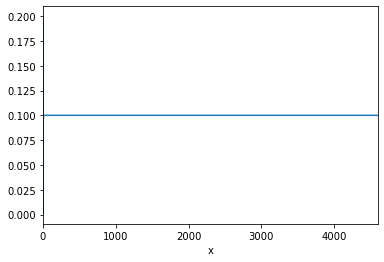

In [15]:
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
itn=f
xl=np.array(range(0,itn))
y=np.empty(itn)
for l in range(0,itn):
    y[l]=ip[l][0]
plt.xlim(0,itn)
plt.plot(xl[0:itn],y[0:itn])
plt.xlabel('x')

Text(0.5, 0, 'x')

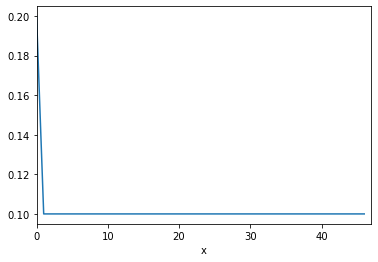

In [11]:
itn=len(p)
xl=np.array(range(0,itn))
y=np.empty(itn)
for l in range(0,itn):
    y[l]=p[l][0]
plt.xlim(0,itn)
plt.plot(xl[0:itn],y[0:itn])
plt.xlabel('x')

## RRT Code

- If we are at a local minima:
- Initiate RRT to determine the rest of the waypoints to the goal
- Increment from 1 waypoint from the minima
- if we are at local minima after following waypoint, increase the waypoints to follow
- repeat process till goal is reached

In [128]:
def boundaryCollision(point, boundary):
    outOfBounds = False
    # print("================ Boundary Collision ================")
    # print("Point " + str(point))

    f = calculateFK()

    # All the joint XYZ values
    # Use index 0 for start and goal because they are
    # nested lists
    startPos, _ = f.forward(point[0])

    for i in range(len(startPos)):

        # Check if joint i is within the boundary
        outOfBounds |= (startPos[i][0] < boundary[0])
        outOfBounds |= (startPos[i][1] < boundary[1])
        outOfBounds |= (startPos[i][2] < boundary[2])
        outOfBounds |= (startPos[i][0] > boundary[3])
        outOfBounds |= (startPos[i][1] > boundary[4])
        outOfBounds |= (startPos[i][2] > boundary[5])

    return outOfBounds

def obstacleCollision(start, goal, obstacles):
    """
    start is a pose containing q1 -> qe
    goals is a pose containing q1 -> qe
    returns if there is a feasible straight line path
    """
    lineCollision = False
    # print("================ Obstacle Collision ================")
    # print("lineCollision is " + str(lineCollision))
    # print("Start " + str(start))
    # print("Goal " + str(goal))

    f = calculateFK()

    # All the joint XYZ values
    # Use index 0 for start and goal because they are
    # nested lists
    startPos, _ = f.forward(start[0])
    goalPos, _ = f.forward(goal[0])

    # print("StartPos " + str(startPos))
    # print("GoalPos " + str(goalPos))

    for obstacle in obstacles:
        # Iterate through every joint
        for i in range(len(startPos)):
            results = detectCollision([startPos[i]], [goalPos[i]], obstacle)
            for result in results:
                lineCollision |= result

    # print("lineCollision is " + str(lineCollision))
    return lineCollision

def postProcessing(points, obstacles):
    if len(points)<=5:
        return points
    processed = deepcopy(points)

    efficiency = 0
    i = 0
    maxIter = len(points)
    while(i < maxIter):

        a = random.randrange(1, len(processed) - 1)
        b = random.randrange(1, len(processed) - 1)

        # b is always larger than a
        if b == a: continue
        if(b < a): a, b = b, a

        if(a == b): continue
        coll = obstacleCollision([processed[a]], [processed[b]], obstacles)

        if not coll:
            efficiency += b - a -1
            # print("Eliminated %i elements"%(b-a - 1))

            y = 0
            for x in range(len(processed)) :
                if x <= a or x >= b :
                    processed[y] = processed[x]
                    y += 1
            processed = processed[:len(processed) - (b - a - 1)]
        i += 1

    # verify collision free path exists
    verificationFlag = True
    verificationFlag &= (points[0] == processed[0])
    verificationFlag &= (points[-1] == processed[-1])
    for i in range(len(processed) - 1):
        if obstacleCollision([processed[i]], [processed[i + 1]], obstacles):
            verificationFlag &= False

    if not verificationFlag:
        print ("Something is wrong in post-processing")
        print(processed)

    return processed

def rrt(map, start, numPoints):
    obstacles = deepcopy(map.obstacles)
    base1 = np.array([[-30,-30,0.5,-0.1,-0.1,80]])
    base2 = np.array([[0.1,0.1,0.1,30,30,80]])
    boundary = deepcopy(map.boundary)
    bufferRadius = 40

    for obstacle in obstacles:
        obstacle[0] = max(obstacle[0] - bufferRadius, boundary[0])
        obstacle[1] = max(obstacle[1] - bufferRadius, boundary[1])
        obstacle[2] = max(obstacle[2] - bufferRadius, boundary[2])
        obstacle[3] = min(obstacle[3] + bufferRadius, boundary[3])
        obstacle[4] = min(obstacle[4] + bufferRadius, boundary[4])
        obstacle[5] = min(obstacle[5] + bufferRadius, boundary[5])

    # check if start or goal pose is inside a C-space obstacle
    startObstacle = obstacleCollision([start], [start], obstacles)
    obstacles=np.append(obstacles,base1,axis=0)
    obstacles=np.append(obstacles,base2,axis=0)
    if(startObstacle):
        print("Target or Start inside obstacle")
        return ([])
    
    if(len(obstacles) != 0):
        obstacles=np.append(obstacles,base1,axis=0)
        obstacles=np.append(obstacles,base2,axis=0)
    else:
        obstacles=base1
        obstacles=np.append(obstacles,base2,axis=0)
        
    # in the list
    points = [list(start)]
    maxIter = numPoints
    i = 0

    # Lower joint limits in radians (grip in mm
    # (negative closes more firmly))
    lowerLim = [-1.4, -1.2, -1.8, -1.9, -2.0, -15]

    # Upper joint limits in radians (grip in mm)
    upperLim = [1.4, 1.4, 1.7, 1.7, 1.5, 30]
    
    currentPose = start
    
    print("(1) Above RRT While")

    while (i < maxIter):
        # sample a pose
        randQ1 = random.uniform(lowerLim[0], upperLim[0])
        randQ2 = random.uniform(lowerLim[1], upperLim[1])
        randQ3 = random.uniform(lowerLim[2], upperLim[2])
        randQ4 = random.uniform(lowerLim[3], upperLim[3])
        randQE = random.uniform(lowerLim[4], upperLim[4])
        
        print("(2.1) Generated RRT point")

        newPose = [randQ1, randQ2, randQ3, randQ4, randQE, 0]
        #print(i, newPose)

        coll = obstacleCollision([currentPose],[newPose], obstacles)
        coll |= boundaryCollision([currentPose], boundary)

        if not coll:
            points.append(list(newPose))
            currentPose = newPose
            i += 1
        if i==maxIter:
            print("max iterations reached")
            break
            
    return points

In [23]:
def detectCollision (linePt1, linePt2, box):
    """
    Check if multiple lines formed from two points intercepts with the block.
    Check one at a time.
    :param linePt1: [n,3] np array where each row describes one end of a line
    :param linePt2  [n,3] np array where each row describes one end of a line
    :param box [xmin, ymin, zmin, xmax, ymax, zmax]: box
    :return: n dimensional array, true if line n is in collision with the box
    """
    n_samples = len(linePt1)
    return [detectCollisionOnce(linePt1[index], linePt2[index], box) for index in range(n_samples)]

def detectCollisionOnce(linePt1, linePt2, box):
    """
    Check if line form from two points intercepts with the per block.
    Check one at a time.
    :param linePt1 [x,y,z]:
    :param linePt2 [x,y,z]:
    :param box [xmin, ymin, zmin, xmax, ymax, zmax]:
    :return: true if collision, otherwise false
    """
    # %% Initialization
    # box = box[0]
    # Initialize all lines as collided.
    isCollided = np.ones(1)

    # Divide box into lower left point and "size"
    boxPt1 = np.array([box[0],box[1], box[2]])
    # Create point in the opposize corner of the box
    boxPt2 = np.array([box[3],box[4], box[5]])
    boxSize = boxPt2 - boxPt1
    # Find slopes vector
    lineSlope = linePt2 - linePt1
    lineSlope = [0.001 if num == 0 else num for num in lineSlope]

    # %% Begin Collision Detection

    # The parameter t = [0,1] traces out from linePt1 to linePt2

    # Return false if box is invalid or has a 0 dimension
    if min(boxSize) <= 0:
        isCollided = 0 * isCollided
        return isCollided

    # Get minimum and maximum intersection with the y-z planes of the box
    txmin = (boxPt1[0] - linePt1[0]) / lineSlope[0]
    txmax = (boxPt2[0] - linePt1[0]) / lineSlope[0]

    # Put them in order based on the parameter t
    ts = np.sort(np.array([txmin,txmax]).transpose())
    txmin = ts[0]
    txmax = ts[1]


    # Get minimum and maximum intersection with the x-z planes of the box

    tymin = (boxPt1[1] - linePt1[1]) / lineSlope[1]
    tymax = (boxPt2[1] - linePt1[1]) / lineSlope[1]

    # Put them in order based on the parameter t
    ts = np.sort(np.array([tymin, tymax]).transpose())
    tymin = ts[0]
    tymax = ts[1]
    # if we miss the box in this plane, no collision
    isCollided = np.logical_and(isCollided, np.logical_not(np.logical_or((txmin > tymax), (tymin > txmax))))

    # identify the parameters to use with z
    tmin = np.maximum.reduce([txmin, tymin])
    tmax = np.minimum.reduce([txmax, tymax])

    # Get minimum and maximum intersection with the x-z planes of the box
    tzmin = (boxPt1[2] - linePt1[2]) / lineSlope[2]
    tzmax = (boxPt2[2] - linePt1[2]) / lineSlope[2]
    # Put them in order based on the parameter t
    ts = np.sort(np.array([tzmin, tzmax]).transpose())
    tzmin = ts[0]
    tzmax = ts[1]

    # if we miss the box in this plane, no collision
    isCollided = np.logical_and(isCollided, np.logical_not(np.logical_or((tmin > tzmax), (tzmin > tmax))))

    # identify the parameters to use with z
    tmin = np.maximum.reduce([tmin, tzmin])
    tmax = np.minimum.reduce([tmax, tzmax])

    # check that the intersecion is within the link length
    isCollided = np.logical_and(isCollided, np.logical_not(np.logical_or((0 > tmax), (1 < tmin))))
    isCollided = isCollided.reshape((isCollided.shape[0],1))
    return isCollided[0,0]